Accompanying notebook for the talk *Designing **with** data* by <a href="https://www.linkedin.com/in/joshuanewnham">Joshua Newnham</a> - 2017

# Data pre-processing 

In this notebook we prepare data for training our model; the process follows the following steps:  
- Ingestion 
- Cleaning 
- Normalising 
- Building a vocabulary
- Tokenising 
- Vectorization 
- Padding 

We will be using transcripts from the popular TV soap show Friends to train our chatbot, specifically using the dialogue from Joey, one of the main characters of the show.  
We are using the data made available from <a href="https://sites.google.com/site/friendstvcorpus/">friendstvcorpus</a>; curated by David Ayliffe for his Masters thesis 'A study into the use of linguistic structures used inter-gender and intra-gender in the TV show 'Friends'. 

In [1]:
import constants

import csv 
import pickle 
import collections 
import itertools
import copy
import operator
import re 
import random 

import numpy as np

import matplotlib.pyplot as plt

from keras.preprocessing import sequence

Using TensorFlow backend.


In [2]:
%matplotlib inline
plt.style.use('ggplot')

## Data Ingestion

In this phase we will import the data from the files available <a href="https://sites.google.com/site/friendstvcorpus/files/Data.zip?attredirects=0&d=1">here</a>. The file is tab delimitted, with the following columns: 
- 0: id
- 1: scene_id
- 2: person
- 3: gender
- 4: original_line
- 5: line
- 6: metadata
- 7: filename

In [3]:
def read_file():
    
    conversation = [] 
    
    with open(constants.FILE_TRAINING_DATA) as f:
        reader = csv.reader(f, delimiter='\t')
        _ = next(reader)
        for row in reader:
            try:
                scene_id = int(row[1].strip())
            except:
                continue 
                
            person = row[2].strip() 
            line = row[5].strip() 
            
            conversation.append({
                'scene_id': scene_id, 
                'actor': person, 
                'text': line})
            
    return conversation

In [4]:
conversation = read_file()

print("Separate dialouge instances {}\n".format(len(conversation)))

for i in range(3):
    idx = random.randint(0, len(conversation)-10)
    print("{}: {}: {}".format(idx-1, conversation[idx-1]["actor"], conversation[idx-1]["text"]))
    print("{}: {}: {}".format(idx, conversation[idx]["actor"], conversation[idx]["text"]))
    print("{}: {}: {}".format(idx+1, conversation[idx+1]["actor"], conversation[idx+1]["text"]))
    print("")

Separate dialouge instances 60847

39806: ROSS: Okay, I'm going to start climb down you now.
39807: JOEY: Alright! Just hurry up!
39808: ROSS: Okay. Now now now should I climb down your front so we're face to face or-or should I climb down your back so we're we're butt to face.

43207: CHANDLER: And the world will never know.
43208: JOEY: Hey! Did you talk to Dennis about me yet?
43209: CHANDLER: Yes, I told him how talented you were. I told him all about Days Of Our Lives.

26645: CHANDLER: This took you all day?!
26646: JOEY: No no, this only took five minutes. I spent the rest of the day coming up with new, Ultimate Fireball. Ha-ha!
26647: JOEY: Okay, it's a typical New York City apartment. Two girls are just hanging out.



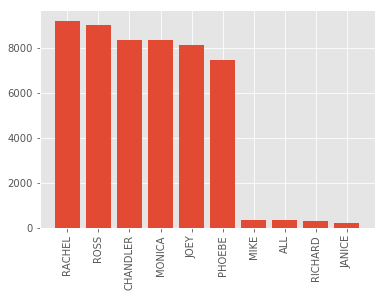

In [5]:
# lets count how often each person spoke 
actor_counts = {} 

for c in conversation:
    actor = c['actor']
    if actor not in actor_counts:
        actor_counts[actor] = 0
        
    actor_counts[actor] += 1
    
sorted_actor_counts = sorted(actor_counts.items(), key=operator.itemgetter(1), reverse=True)


N = 10
plt.bar(range(N), [float(item[1]) for item in sorted_actor_counts[:N]], align='center')
plt.xticks(range(N), [item[0] for item in sorted_actor_counts[:N]], rotation=90)
plt.show()

In [6]:
# now examine the length of each sentence to find what sequence length we should use 
utterances_len = [] 

for c in conversation:
    utterances_len.append(len(c["text"].split()))
    
print("Utterances: Min: {}, Max: {}, Mean: {}".format(
    min(utterances_len), max(utterances_len), 
    round(float(sum(utterances_len))/float(len(utterances_len)),2)))

Utterances: Min: 1, Max: 195, Mean: 10.16


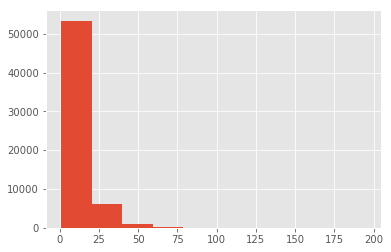

In [7]:
# lets look at the distribution
plt.hist(utterances_len)
plt.show()

In [8]:
# lets remove utterances with > 30 words 
utterances_len = [l for l in utterances_len if l <= 30]
print("Utterances: Min: {}, Max: {}, Mean: {}".format(
    min(utterances_len), max(utterances_len), 
    round(float(sum(utterances_len))/float(len(utterances_len)),2)))

Utterances: Min: 1, Max: 30, Mean: 8.52


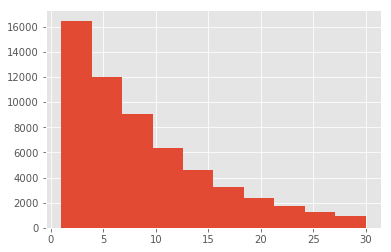

In [9]:
plt.hist(utterances_len)
plt.show()

Given the mean is 8 and distribution is considerable on the left, lets make our max sentence length 15 (defined in constants.py).

In [10]:
"""
lets now extract all conversation pairs with X and 'MAIN ACTOR' - here X 
is any person who speaks to 'MAIN ACTOR'. X utterance will be used as a input into our 
encoder and the response from 'MAIN ACTOR' our input into our decoder 
(we'll get to this soon) 
"""

MAIN_ACTORS = ["JOEY"]

extracted_conversation_encoder = [] 
extracted_conversation_decoder = [] 

prev_dialogue = None 

for dialogue in conversation:
    
    if prev_dialogue is not None:
        if dialogue['actor'] in MAIN_ACTORS and dialogue["actor"] is not prev_dialogue["actor"] \
            and dialogue['scene_id'] == prev_dialogue['scene_id']:
                extracted_conversation_encoder.append(prev_dialogue['text'])
                extracted_conversation_decoder.append(dialogue['text'])
                
    prev_dialogue = dialogue            

In [11]:
print("Number of pairs {}".format(len(extracted_conversation_decoder)))

Number of pairs 7723


In [12]:
print("Examples:")
for i in range(3):
    print("{}: {}\n{}: {}\n".format(
        i, extracted_conversation_encoder[i], i, extracted_conversation_decoder[i]))

Examples:
0: Then I look down, and I realize there's a phone... there.
0: Instead of...?

1: That's right.
1: Never had that dream.

2: Hi.
2: This guy says hello, I wanna kill myself.



## Data Normalisation

Here we simply lowercase all the text as, in this instance, we don't want words with different cases to have different meaning.

In [13]:
extracted_conversation_encoder = [text.lower() for text in extracted_conversation_encoder]
extracted_conversation_decoder = [text.lower() for text in extracted_conversation_decoder]

In [14]:
print("Examples:")
for i in range(3):
    print("{}: {}\n{}: {}\n".format(
        i, extracted_conversation_encoder[i], i, extracted_conversation_decoder[i]))

Examples:
0: then i look down, and i realize there's a phone... there.
0: instead of...?

1: that's right.
1: never had that dream.

2: hi.
2: this guy says hello, i wanna kill myself.



## Cleaning

Once we have our utterances; our next step is cleaning it. In traditional text processing this would include removing punctuation, removing stop words, potentially stemming or lemmatization. In this case, we will simply remove punctuation.

In [15]:
replacements = [
    ("wan't", "want"), 
    ("didn't", "did not"), 
    ("don't", "did not"),  
    ("won't", "will not"),
    ("can't", "can not"), 
    ("we'd", "we would"), 
    ("i'd", "i would"),    
    ("c'mon", "come on"), 
    ("n't", " not"), 
    ("’ve", " have"), 
    ("'ll", " will"), 
    ("'m", " am"), 
    ("'t", " not"), 
    ("'re", " are"), 
    ("'s", " is"), 
    ("'d", " would")    
]      

for i, line in enumerate(extracted_conversation_encoder):
    for key, value in replacements:
        extracted_conversation_encoder[i] = extracted_conversation_encoder[i].replace(key, value)
        
for i, line in enumerate(extracted_conversation_decoder):
    for key, value in replacements:
        extracted_conversation_decoder[i] = extracted_conversation_decoder[i].replace(key, value)

In [16]:
extracted_conversation_encoder = [re.sub(r"[^a-zA-Z0-9]", " ", text) for text in extracted_conversation_encoder]
extracted_conversation_decoder = [re.sub(r"[^a-zA-Z0-9]", " ", text) for text in extracted_conversation_decoder]

In [17]:
print("Examples:")
for i in range(3):
    print("{}: {}\n{}: {}\n".format(
        i, extracted_conversation_encoder[i], i, extracted_conversation_decoder[i]))

Examples:
0: then i look down  and i realize there is a phone    there 
0: instead of    

1: that is right 
1: never had that dream 

2: hi 
2: this guy says hello  i wanna kill myself 



## Build up a vocabulary

Our next step is to build up a vocabulary; this is what we will use to teach our model.

In [18]:
# join both our encoder and decoder lists together and build a large set which we'll then 
# pass to the Counter that, conveniently and as you would expect, counters occurrences of each 
# word 
vocab = extracted_conversation_encoder + extracted_conversation_decoder
vocab = " ".join(vocab) 
vocab = vocab.split()

word_counts = collections.Counter(vocab)

print("Corpus has {} unique words".format(len(word_counts)))

Corpus has 7270 unique words


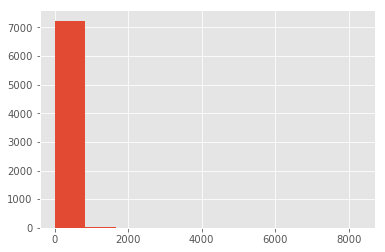

In [19]:
word_counts_only = [count for word, count in word_counts.items()]
plt.hist(word_counts_only)
plt.show()

In [20]:
# lets limit it to words that occured at least twice (adding on the number of tags we'll use)
vocab_size = sum(1 for word, count in word_counts.items() if count >= 4) + len(constants.TAGS)
print("Vocab size {}".format(vocab_size))

Vocab size 2193


In [21]:
vocab = word_counts.most_common(vocab_size - len(constants.TAGS))

In [22]:
# print some stats
print("vocab size {}, most frequent word '{}' ({}), least freqent word = '{}' ({})".format(
    len(vocab), vocab[0][0], vocab[0][1], vocab[-1][0], vocab[-1][1]))

vocab size 2189, most frequent word 'i' (8290), least freqent word = 'hut' (4)


In [23]:
# create index_2_word and word_2_index lookups 
word_2_index = copy.copy(constants.TAGS)

for v_i, v in enumerate(vocab, len(constants.TAGS)):
    word_2_index[v[0]] = v_i

index_2_word = {v_i: v for v, v_i in word_2_index.items()}

In [24]:
print("First 20 words in our index")
for i in range(20):
    print("{} = {}".format(i, index_2_word[i]))

First 20 words in our index
0 = <PAD>
1 = <EOS>
2 = <UNK>
3 = <BOS>
4 = i
5 = you
6 = is
7 = the
8 = not
9 = it
10 = to
11 = a
12 = that
13 = and
14 = what
15 = are
16 = did
17 = know
18 = am
19 = oh


In [25]:
# lets now save our lookups 
with open(constants.FILE_VOCAB, 'wb') as f:
    pickle.dump([index_2_word, word_2_index], f)

## Tokenize

Next we break each sentence into tokens (aka words) - the reason for doing this will become clear as we move on.

In [26]:
tokens_encoder = [text.split() for text in extracted_conversation_encoder]
tokens_decoder = [text.split() for text in extracted_conversation_decoder]

In [27]:
print("Examples:")
for i in range(3):
    print("{}: {}\n{}: {}\n".format(
        i, tokens_encoder[i], i, tokens_decoder[i]))

Examples:
0: ['then', 'i', 'look', 'down', 'and', 'i', 'realize', 'there', 'is', 'a', 'phone', 'there']
0: ['instead', 'of']

1: ['that', 'is', 'right']
1: ['never', 'had', 'that', 'dream']

2: ['hi']
2: ['this', 'guy', 'says', 'hello', 'i', 'wanna', 'kill', 'myself']



Now lets replace words that we don't exist in our vocab with our UNK tag.

In [28]:
# update our tokenized inputs and outputs, replacing all words no in the vocab with the unknown tag 
for i, words in enumerate(tokens_encoder):
    tokens_encoder[i] = [w if w in word_2_index else constants.TAG_UNK for w in words]
    
for i, words in enumerate(tokens_decoder):
    tokens_decoder[i] = [w if w in word_2_index else constants.TAG_UNK for w in words]

Our final 2 tasks are to truncate utterances that are too long and surround our decoder utterances with our BOS (begining of sentence) and EOS (end of sentence) tags. This will give our model clues as to when a sentence starts and end.

In [29]:
# reduce size of our question and answer 
for i, tokens in enumerate(tokens_encoder):
    if len(tokens) > constants.MAX_INPUT_LENGTH:
        tokens_encoder[i] = tokens[:constants.MAX_INPUT_LENGTH]  
        
for i, tokens in enumerate(tokens_decoder):
    # similar to the encoder but reducing the max length by 2 to 
    # allow for the BOS and EOS tags
    if len(tokens) > constants.MAX_INPUT_LENGTH-2:
        tokens_decoder[i] = tokens[:constants.MAX_INPUT_LENGTH-2]  
        
    tokens_decoder[i].insert(0, constants.TAG_BOS)
    tokens_decoder[i].append(constants.TAG_EOS)

In [30]:
print("Examples:")
for i in range(3):
    print("{}: {}\n{}: {}\n".format(
        i, tokens_encoder[i], i, tokens_decoder[i]))

Examples:
0: ['then', 'i', 'look', 'down', 'and', 'i', 'realize', 'there', 'is', 'a', 'phone', 'there']
0: ['<BOS>', 'instead', 'of', '<EOS>']

1: ['that', 'is', 'right']
1: ['<BOS>', 'never', 'had', 'that', 'dream', '<EOS>']

2: ['hi']
2: ['<BOS>', 'this', 'guy', 'says', 'hello', 'i', 'wanna', 'kill', 'myself', '<EOS>']



## Vectorize the utterances

Very few machine learning algorithms can accept anything but numerical values, partly for this reason we will vectorise our text. This means we will replace a word with it's associated id via the lookup created above (index_2_word) e.g. ['you', 'did', 'not'] becomes [5, 16, 8].

In [31]:
# Creating the training data:
vec_encoder = np.asarray([[word_2_index[w] for w in sent] for sent in tokens_encoder])
vec_decoder = np.asarray([[word_2_index[w] for w in sent] for sent in tokens_decoder])

In [32]:
print("Examples:")
for i in range(3):
    print("{}: {}\n{}: {}\n".format(
        i, vec_encoder[i], i, vec_decoder[i]))

Examples:
0: [89, 4, 59, 124, 13, 4, 1004, 46, 6, 11, 361, 46]
0: [3, 791, 26, 1]

1: [12, 6, 57]
1: [3, 125, 110, 12, 735, 1]

2: [152]
2: [3, 23, 101, 362, 242, 4, 137, 514, 336, 1]



In [33]:
"""
reverse the encoder inputs i.e. from a, b, c => 1, 2, 3 (where a, c, b are the inputs
for the encder and 1, 2, 3 are the inputs for the decoder) to c, d, a => 1, 2, 3. This 
assist our network in finding a relationship between a and 1 etc 
"""
for i in range(len(vec_encoder)):
    vec_encoder[i] = vec_encoder[i][::-1]

In [34]:
print("Examples:")
for i in range(3):
    print("{}: {}\n{}: {}\n".format(
        i, vec_encoder[i], i, vec_decoder[i]))

Examples:
0: [46, 361, 11, 6, 46, 1004, 4, 13, 124, 59, 4, 89]
0: [3, 791, 26, 1]

1: [57, 6, 12]
1: [3, 125, 110, 12, 735, 1]

2: [152]
2: [3, 23, 101, 362, 242, 4, 137, 514, 336, 1]



## Padding 

Our final task is to pad each of the vectors such that they are all the same length. This is because our model cannot deal with variable sized vectors - and if it could we would still probably do it to make its job of learning easier.

In [35]:
# pad our each sequence to ensure they are the same length (fixed size of MAX_INPUT_LENGTH, MAX_OUTPUT_LENGTH)
padded_vec_encoder = sequence.pad_sequences(vec_encoder, maxlen=constants.MAX_INPUT_LENGTH)
padded_vec_decoder = sequence.pad_sequences(vec_decoder, maxlen=constants.MAX_OUTPUT_LENGTH, padding='post')

In [36]:
print("Examples:")
for i in range(3):
    print("{}: {}\n{}: {}\n".format(
        i, padded_vec_encoder[i], i, padded_vec_decoder[i]))

Examples:
0: [   0    0    0   46  361   11    6   46 1004    4   13  124   59    4   89]
0: [  3 791  26   1   0   0   0   0   0   0   0   0   0   0   0]

1: [ 0  0  0  0  0  0  0  0  0  0  0  0 57  6 12]
1: [  3 125 110  12 735   1   0   0   0   0   0   0   0   0   0]

2: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 152]
2: [  3  23 101 362 242   4 137 514 336   1   0   0   0   0   0]



In [37]:
# lets now save our padded vectors - this is what we will feed our machine learning algorithm. 
with open(constants.FILE_TRAINING_DATA_ENCODER_INPUTS, 'wb') as f:
    pickle.dump(padded_vec_encoder, f)
    
with open(constants.FILE_TRAINING_DATA_DECODER_INPUTS, 'wb') as f:
    pickle.dump(padded_vec_decoder, f)